In [159]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from nltk.stem.snowball import SnowballStemmer
import nltk
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import re

In [160]:
dataset_path = './archive/train.csv'
data_column  = 'tweet'
TRESHOLD	 = .2

Load the data from the csv file using panda library

In [161]:
df = pd.read_csv(dataset_path)
df.head()

,count,hate_speech_count,offensive_language_count,neither_count,class,tweet
0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


**Preprocessing data**

Tweets are typed with a lot of mistakes.
The first preprocess step is the `reduce_repetition` function. It will transform a character sequence `aaaaa` into one characters `a` but keeping 2-letters sequences for words like 'wi**ll**', 'g**oo**d', 'he**ll**o'... Thus, the model will handle similar data even if people typed mutliple time the same letter without noticing it

In [162]:
def reduce_repetition(s):
    # use regular expression to find repeated substrings
    pattern = re.compile(r'(.+?)\1{%d,}' % 2)
    match = pattern.search(s)

    # reduce repetition to two occurrences
    while match:
        repeated_substring = match.group(1)
        s = s.replace(match.group(), repeated_substring, 1)
        match = pattern.search(s)

    return s

In [163]:
print(reduce_repetition('hello everyyyone IIII will present mysellllllf'))
print(reduce_repetition('aaaaaxxxooooooo ll'))

hello everyone I will present myself
axo ll


After this, I started looking at unknown words that usually appears and corrected them

In [164]:
abbr = {
    'ninstagram'        : 'instagram',
    'instagramgram'     : 'instagram',
    'ig'                : 'instagram',
    'strainstagramht'   : 'instagram',
    'insta'             : 'instagram',
    'rinstagramht'      : 'instagram',
    'ninstagramguh'     : 'instagram',
    'instagramz'        : 'instagram',
    'sinstagramn'       : 'instagram',
    'binstagramgest'    : 'instagram',
    'pinstagram'        : 'instagram',
    'linstagramht'      : 'instagram',
    'ninstagramg'       : 'instagram',
    'instagramh'        : 'instagram',
    'instagramnor'      : 'instagram',
    'ninstagramht'      : 'instagram',
    'ninstagramgramga'  : 'instagram',
    'finstagramht'      : 'instagram',
    'binstagram'        : 'instagram',
    'hinstagramh'       : 'instagram',
    'ninstagramga'      : 'instagram',
    'toninstagramht'    : 'instagram',
    'minstagramht'      : 'instagram',
    'minstagramt'       : 'instagram',
	
	'nigger'			: 'nigga',
	'niggah'			: 'nigga',
	'nigguh'			: 'nigga',
	'niccuh'			: 'nigga',
	'nicca'				: 'nigga',
	'nig'				: 'nigga',
	
	
    'dwn'               : 'down',
    'dawn'              : 'down',

    'ta'                : 'that',
    'dat'               : 'that',

	'yank'				: 'yankee',
    'dawg'              : 'dude',
    'smh'               : 'head',
    'fr'                : 'real',
    'plz'               : 'please',
    'tf'                : 'wtf',
    'theyr'             : 'are',
    'bc'                : 'because',
    'af'                : 'lot',
    'u'                 : 'you',
    'ppl'               : 'people',
    'dm'                : 'message',
    'bf'                : 'friend',
    'gt'                : 'getting',
    'ya'                : 'yes',
    'na'                : 'no',
    'ur'                : 'your',
    'tryna'             : 'to',
    'lmfao'             : 'lmao',
    'ive'               : 'have'
}

In [165]:
sentence = ' u think ur ninstagramgramga dm tryna gt bf works'

print("original sentence: ", sentence)

for old in abbr:
    new = abbr[old]
    sentence = sentence.replace( ' ' + old + ' ', ' ' + new + ' ' ) # add some space arround the world to avoid matching a part of a word

print("corrected sentence:", sentence)

original sentence:   u think ur ninstagramgramga dm tryna gt bf works
corrected sentence:  you think your instagram message to getting friend works


Usually the end sentence marker is `.`. A problem with that is this kind of sentence:
`Dear Mr. hopkins, Dear Mrs. Christie, I've been struggling with many problems... waiting for your help`

In [166]:
def remove_points(line):
    l = list(line)

    for i in range(len(l)):
        # print(i, "\t", l[i], "\t", l[i+2])
        if i < len(l) - 2 and l[i] == '.' and (l[i+2] < 'A' or l[i+2] > 'Z'):
            l[i] = ' '

    line = ''.join(l)
    return line

In [167]:
sentence = "Dear Mr. hopkins, Dear Mrs. Christie, I've been struggling with many problems... waiting for your help"
print("original sentence: ", sentence)

sentence = remove_points(sentence)

print("corrected sentence:", sentence)

original sentence:  Dear Mr. hopkins, Dear Mrs. Christie, I've been struggling with many problems... waiting for your help
corrected sentence: Dear Mr  hopkins, Dear Mrs. Christie, I've been struggling with many problems    waiting for your help


The result is interesting but I didn't figured out how to do it for a name that starts with a capital letter: **C**hristie in this case

Let's load a stemmer and put all of the previous functions in a big function:

- replace some username by `username`
- replace some web links by `weblink`
- replace some `&amp` by `&`
- delete the emojis `UTF-8` code: eg. &#128514

In [168]:
stemmer = SnowballStemmer('english')

In [169]:
def preprocess(sentence, get='stems'):
    sent = re.sub(r'@([a-zA-Z0-9_]+)'	, 'username', sentence).replace('username:', '') # replace first username
    sent = re.sub(r'http?://\S+'		, 'weblink'	, sent	  )
    sent = re.sub(r'&amp'				, '&'		, sent	  )
    sent = re.sub(r"&#\d+"				, ''		, sent	  )
    
    if sent and sent[0] == '.':
        sent = sent[1:]

    sent = remove_points(sent)
    
    sent = sent   		.replace('RT', '').replace('!', ' ').replace('"', '').replace("\n", ' ')\
                        .replace(';', ' ').replace('-', ' ').replace(' and ', ' & ').replace('\'', '')\
                        .replace('?', '.').replace(',', '').replace('~', ' ').replace('|', ' ').replace('°', ' ')\
                        .replace('`', ' ').replace('~', ' ').replace('*', ' ').replace('+', ' ').replace('/', ' ')\
                        .replace(' # ', ' ').replace('http', ' ').replace('t.co', ' ').replace('\\', ' ').replace('&#', ' ')
    for _ in range(4):
        sent = sent.replace('  ', ' ').replace('..', '.').replace(' .', '.') # remove multiple points & space
    
    if sent and sent[0] == ' ':
        sent = sent[1:]

    sent = sent.lower()

    for old in abbr:
        new = abbr[old]
        sent = sent.replace( ' ' + old + ' ', ' ' + new + ' ' ) # add some space arround the world to avoid matching a part of a word

    sent = reduce_repetition(sent)

    if get == 'sentence':
        return sent
    
    tokens = nltk.word_tokenize(sent)

    for i in range(len(tokens) - 1, 0, -1):
        if len(tokens[i].strip()) == 0 or (len(tokens[i].strip()) == 1 and tokens[i].strip() != 'a' and tokens[i].strip() != 'i' and tokens[i].strip() != '&'):
            tokens.pop(i)

    if get == 'tokens':
        return tokens

    stems = []

    for tok in tokens:
        stems.append(stemmer.stem(tok))

    for i in range(len(stems) - 1, 0, -1):
        if len(stems[i].strip()) == 0:
            stems.pop(i)
        elif len(stems[i].strip()) == 1:
            if 'a' < stems[i].strip() <= 'z'and stems[i].strip() != 'i':
                stems.pop(i)


    for i in range(len(stems) - 1, 0, -1):
        arr = stems[i].split('.')
        stems[i] = arr[0]
        for j in range(1, len(arr)):
            stems.insert(i+j, arr[j])

    for i in range(len(stems)):
        if stems[i] in abbr.keys():
            stems[i] = abbr[stems[i]]

    return stems

In [170]:
sentence = '@epsilon u. think ur..ninstagramgramga dm tryna gt bf workssssss heres my soooolutionnn &#128514 http://youtube.com '

print(" ".join(preprocess(sentence)))

usernam you think your instagram messag to get friend work here my solut weblink


Here we are so far. This solution will allow us to compute the same data for two sentences that may be different without preprocessing. Let's apply the preprocessing to our data:

In [171]:
df['processed_text'] = df[data_column].apply(preprocess)
df['processed_text_str'] = df['processed_text'].apply(lambda x: " ".join(x))

Creating a **TF-IDF Vectorizer** with a parameter `max_features=5000`. This means the vectorizer will convert the **text** data **into** a **matrix** of TF-IDF features but will only **consider the top 5000 terms** ordered by term **frequency** across the corpus. TF-IDF stands for Term Frequency-Inverse Document Frequency, a numerical statistic that reflects **how important a word is to a document** in a collection or corpus.

Transforming Text Data: The `fit_transform` method is used to **learn the vocabulary** and the IDF from the training data. It then transforms this text data into a **dense matrix** of TF-IDF features. The `.toarray()` method converts this matrix from a sparse format, which is the default output of the fit_transform method, into a **dense array** format.

Let's run it !

In [172]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = tfidf_vectorizer.fit_transform(df['processed_text_str']).toarray()

Let's now create a function that will label the data as hate or not

In [173]:
def label_tweet(row):
    """
    - Hate: If hate_speech_count is the highest count.
    - Offensive: If offensive_language_count is the highest count.
    - Hate & Offensive: If hate_speech_count and offensive_language_count are equal and higher than neither_count.
    - Neither: If neither_count is the highest count.
    """
    if row['hate_speech_count'] > row['offensive_language_count'] and row['hate_speech_count'] > row['neither_count']:
        return 'hate'
    elif row['offensive_language_count'] > row['hate_speech_count'] and row['offensive_language_count'] > row['neither_count']:
        return 'hate'
    elif row['hate_speech_count'] == row['offensive_language_count'] and row['hate_speech_count'] > row['neither_count']:
        return 'hate'
    else:
        return 'neither'

In [174]:
df['label'] = df.apply(label_tweet, axis=1)

initialize a new instance of **LabelEncoder**. This object can **convert** categorical labels into a numeric format where each **unique label** is assigned an integer value.

In [175]:
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df['label'])

Keep the label mapping in mind

In [176]:
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print(label_mapping)

{'hate': 0, 'neither': 1}


Split the data for training & testing

In [177]:
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, y, test_size=0.2, random_state=42)

Create a logistic Regression model

In [178]:
logistic_model = LogisticRegression(max_iter=5000)

Train it

In [179]:
logistic_model.fit(X_train, y_train)

LogisticRegression(max_iter=5000)

Fit on the test values

In [180]:
logistic_predictions = logistic_model.predict_proba(X_test)

Data shape modification

In [181]:
y_pred = np.array([0 if i[1] < TRESHOLD else 1 for i in logistic_predictions])

print(y_test.shape, y_test[:30])
print(y_pred.shape, y_pred[:30])

(4957,) [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0]
(4957,) [0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0]


*Chat-GPT* helped me to make this **model evaluation** function

In [182]:
def evaluate_model(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    return accuracy, precision, recall, f1

In [183]:
logistic_eval = evaluate_model(y_test, y_pred)
print("Accuracy: {:.2f}, Precision: {:.2f}, Recall: {:.2f}, F1 Score: {:.2f}".format(*logistic_eval))

Accuracy: 0.93, Precision: 0.94, Recall: 0.93, F1 Score: 0.93


Chat-GPT helped me making this beautiful confusion matrix

In [184]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(	j, i, format(cm[i, j], fmt),
					horizontalalignment="center",
					color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

**Confusion matrix**

Normalized confusion matrix


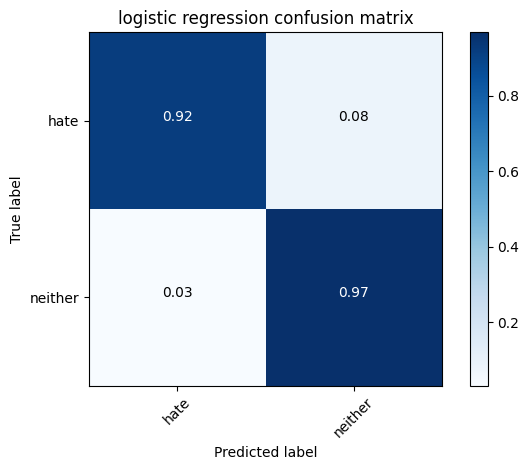

In [185]:
plot_confusion_matrix(y_test, y_pred, classes=label_mapping.keys(), normalize=True, title='logistic regression confusion matrix')

Extract the **most important words** ie those that influence the most the final result

In [186]:
feature_names = tfidf_vectorizer.get_feature_names_out()
coefficients = logistic_model.coef_[0]

feature_importance = sorted(zip(coefficients, feature_names), key=lambda x: abs(x[0]), reverse=True)

print("   Positive\t\t   Negative\n-----------------------------------------\n")

for coef, feat in feature_importance[:30]:
    if coef > 0:
        print(f"{coef:2.2f}:\t{feat}")
    else:
        print(f"\t\t\t{coef:2.2f}:\t{feat}")

   Positive		   Negative
-----------------------------------------

			-22.19:	bitch
			-12.10:	hoe
			-10.72:	pussi
			-8.93:	nigga
			-8.53:	fuck
			-7.01:	shit
			-6.35:	faggot
6.12:	bird
			-6.10:	ass
6.08:	yanke
5.45:	charli
5.29:	yellow
			-4.91:	cunt
			-4.74:	fag
			-4.29:	white
4.18:	oreo
4.09:	trash
			-4.02:	retard
3.78:	browni
3.66:	mock
3.58:	sole
3.23:	jihadi
			-3.07:	fuckin
3.06:	color
			-2.86:	dick
2.73:	monkey
			-2.68:	queer
2.64:	zebra
			-2.62:	these
			-2.52:	dyke


Let's test some sentences now

In [225]:
def predict_hate(sentences):

	if type(sentences) is list:

		X_sentences = [" ".join(preprocess(i)) for i in sentences]
		X_sentences = tfidf_vectorizer.transform(X_sentences).toarray()
		predictions = logistic_model.predict_proba(X_sentences)

		for i in range(len(sentences)):
			print(f"{max(min(100 - predictions[i][1]*50/TRESHOLD, 100), 0):.2f}% HATE:\t{sentences[i]}")

	elif type(sentences) is str:
		sentence = [sentences]
		X_sentence = [" ".join(preprocess(i)) for i in sentence]
		X_sentence = tfidf_vectorizer.transform(X_sentence).toarray()
		predictions = logistic_model.predict_proba(X_sentence)

		return max(min(100 - predictions[0][1]*50/TRESHOLD, 100), 0)


In [228]:
sentences = [
			"hello world everyone is happy to be here",
			"r",
			"They are so ugly !",
			"The holidays are so bad when you are here",
			"sun is shining rn, i'll go eat outside",
			"this dude is not my friend",
			"I think i'll just go and book some vacations",
			"you just fucking managed to break my car !?"
			]

predict_hate(sentences)

8.05% HATE:	hello world everyone is happy to be here
0.00% HATE:	r
44.32% HATE:	They are so ugly !
44.87% HATE:	The holidays are so bad when you are here
0.00% HATE:	sun is shining rn, i'll go eat outside
18.93% HATE:	this dude is not my friend
1.98% HATE:	I think i'll just go and book some vacations
85.18% HATE:	you just fucking managed to break my car !?
